In [6]:
%reload_ext autoreload
%autoreload 2

from lib.basis import construct_rotation_matrix
from lib.formatting import bitstring_to_int
from lib.data_loading_legacy import load_measurements, MultiBasisDataLoader
from lib.state_io import load_state_vector

####

import re
from pathlib import Path
from typing import Optional, Tuple, Dict, Any, Sequence, Callable

import numpy as np

import jax
import jax.lax
import jax.numpy as jnp
import optax
from flax.training.train_state import TrainState
from flax.training import checkpoints
from flax import linen as nn
from jaxtyping import PyTree

import matplotlib.pyplot as plt

data_dir = "data"
model_dir = "./models"
model_prefix = "rbm_amp_202506150002_0"

print(f"Data resides in                         : {data_dir}")
print(f"Amplitude RBM checkpoint to be loaded   : {model_dir}/{model_prefix}")

Data resides in                         : data
Amplitude RBM checkpoint to be loaded   : ./models/rbm_amp_202506150002_0


In [26]:
class PairPhaseRBM(nn.Module):
    n_visible: int
    n_hidden: int

    def setup(self):
        zeros = lambda shape: jnp.zeros(shape, dtype=jnp.float32)
        self.W_amp = self.variable('amp', 'W_amp', zeros, (self.n_visible, self.n_hidden))
        self.b_amp = self.variable('amp', 'b_amp', zeros, (self.n_visible,))
        self.c_amp = self.variable('amp', 'c_amp', zeros, (self.n_hidden,))

        self.W_pha = self.param('W_pha', nn.initializers.normal(0.01), (self.n_visible, self.n_hidden))
        self.b_pha = self.param('b_pha', nn.initializers.zeros, (self.n_visible,))
        self.c_pha = self.param('c_pha', nn.initializers.zeros, (self.n_hidden,))

    def _free_energy_amp(self, v):
        return -(v @ self.b_amp.value) - jnp.sum(jax.nn.softplus(v @ self.W_amp.value + self.c_amp.value), -1)

    def _free_energy_pha(self, v):
        return -(v @ self.b_pha) - jnp.sum(jax.nn.softplus(v @ self.W_pha + self.c_pha), -1)

    def compute_phase(self, v: jnp.ndarray) -> jnp.ndarray:
        return -self._free_energy_pha(v)

    @staticmethod
    def rotated_log_prob(rotation_weights, free_energy_lambda, free_energy_mu):
        # weights are stable known values and the phase part is bounded by +-1. We do log_sum_exp only the real part

        computational_log_magnitudes = -0.5 * free_energy_lambda
        computational_phases = -0.5j * free_energy_mu

        max_computational_log_magnitude = jnp.max(computational_log_magnitudes)

        scaled_computational_amplitudes = jnp.exp(computational_log_magnitudes - max_computational_log_magnitude + computational_phases)

        scaled_measurement_amplitude = jnp.vdot(rotation_weights, scaled_computational_amplitudes)

        log_measurement_amplitude = max_computational_log_magnitude + jnp.log(jnp.abs(scaled_measurement_amplitude) + 1e-30)
        return 2 * log_measurement_amplitude


    def __call__(self, measurement_tuple: Tuple) -> jnp.ndarray:
        measurement, basis = measurement_tuple

        local_indices = jnp.array(jnp.nonzero(basis != 0, size=2, fill_value=-1)[0])

        # get the free energies for all computational basis vectors to construct the full state vector
        local_rotation_matrix = construct_rotation_matrix(basis[local_indices])

        # for outcome 00 we pick first row, for 01 second row, etc.
        local_rotation_weights = local_rotation_matrix[bitstring_to_int(measurement[local_indices])]

        # amplitudes mismatching with our Z measurements are 0. There are only 4 remaining amplitudes with the local variations
        local_measurement_combos = jnp.array([[0,0], [0,1], [1,0], [1,1]], dtype=measurement.dtype)
        local_computational_basis_vectors = jnp.tile(measurement, (4, 1)).at[:, local_indices].set(local_measurement_combos)  # (4, n)

        local_free_energy_lambda = self._free_energy_amp(local_computational_basis_vectors)
        local_free_energy_mu = self._free_energy_pha(local_computational_basis_vectors)

        rotated_log_prob = self.rotated_log_prob(local_rotation_weights, local_free_energy_lambda, local_free_energy_mu)
        return rotated_log_prob

In [27]:
def full_basis_loss(
        params: PyTree,
        apply_fn: Callable,
        amp_vars: Dict[str, jnp.ndarray],
        data_tuple: Tuple[jnp.ndarray, jnp.ndarray]) -> jnp.ndarray:

    basis_measurements, bases = data_tuple

    single_sample_loss = lambda m, b: apply_fn({'params': params, 'amp': amp_vars}, (m, b))
    single_basis_loss = lambda ms, b: jnp.mean(jax.vmap(lambda m: single_sample_loss(m, b))(ms))

    return -jnp.sum(jax.vmap(lambda ms, b: single_basis_loss(ms, b))(basis_measurements, bases))


#@jax.jit
def train_step_sgd(state: TrainState, amp_vars: dict, data_tuple: Tuple[jnp.ndarray, jnp.ndarray]) -> Tuple[TrainState, jnp.ndarray]:
    loss_fn = lambda params: full_basis_loss(params, state.apply_fn, amp_vars, data_tuple)

    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss


def train_rbm_pha(
        state:   TrainState,
        amp_vars: Dict[str, jnp.ndarray],
        loader:  "MultiBasisDataLoader",
        num_epochs: int) -> Tuple[TrainState, Dict[int, float]]:

    metrics: Dict[str, float] = {}

    for epoch in range(num_epochs):
        tot_loss  = 0.0
        n_batches = 0

        for data_tuple in loader:
            state, loss = train_step_sgd(state, amp_vars, data_tuple)
            tot_loss  += loss
            n_batches += 1

        avg_loss = float(tot_loss / n_batches)

        metrics[epoch] = dict(loss=avg_loss)

        print(f"Epoch {epoch+1}/{num_epochs} │ Loss: {avg_loss:.4f}")

    return state, metrics

In [28]:
data_dict = load_measurements(data_dir, "w_*.txt")

keys_pha = [k for k in data_dict if 'Z' in k and re.search(r'[XY]', k)]
dict_pha = {k: data_dict[k] for k in keys_pha}

In [29]:
params_amp = checkpoints.restore_checkpoint(ckpt_dir=str(Path(model_dir).resolve()), target=None, prefix=model_prefix)

amp_vars = {"W_amp": params_amp["W"], "b_amp": params_amp["b"], "c_amp": params_amp["c"]}

/Users/Tonni/miniforge3/envs/dlnn2/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


In [30]:
batch_size    = 6400
visible_units = 8
hidden_units  = 16
num_epochs    = 200
init_lr       = 1e-2
weight_decay  = 1

key = jax.random.PRNGKey(0)

model_pha = PairPhaseRBM(n_visible=visible_units, n_hidden=hidden_units)

dummy_meas  = jnp.zeros((visible_units,), dtype=jnp.float32)
dummy_basis = jnp.zeros((visible_units,), dtype=jnp.int8)

vars_pha = model_pha.init(key, (dummy_meas, dummy_basis))

optim = optax.adamw(init_lr, weight_decay=weight_decay)

state_pha = TrainState.create(apply_fn=model_pha.apply, params=vars_pha['params'], tx=optim)

loader_pha = MultiBasisDataLoader(dict_pha, batch_size=batch_size, basis_encoding={'Z': 0, 'X': 1, 'Y': 2}, shuffle=True)

%time state_pha, metrics_pha = train_rbm_pha(state_pha, amp_vars, loader_pha, num_epochs)

[-11.090355 -11.090355 -11.090355 -11.090355]
[-11.090355 -11.081766 -11.090355 -11.081766]
Traced<ShapedArray(float32[4])>with<BatchTrace(level=4/0)> with
  val = Traced<ShapedArray(float32[6400,4])>with<BatchTrace(level=3/0)> with
    val = Array([[[-8.709145  , -3.5453262 , -3.298399  ,  1.0501995 ],
        [-8.687001  , -2.5045967 , -3.268239  ,  0.17582607],
        [-6.626049  , -8.574705  , -8.759494  , -2.644598  ],
        ...,
        [-6.626049  , -8.574705  , -8.759494  , -2.644598  ],
        [-6.626049  , -8.574705  , -8.759494  , -2.644598  ],
        [-8.661007  , -2.9109454 , -3.028144  ,  1.1088476 ]],

       [[-8.661007  , -3.4024944 , -3.2432737 , -0.7368965 ],
        [-8.759494  , -3.2460737 , -3.268239  ,  0.04542255],
        [-6.626049  , -8.741325  , -8.687001  , -3.7863421 ],
        ...,
        [-8.574705  , -4.0436096 , -2.5045967 ,  1.2474861 ],
        [-6.626049  , -8.741325  , -8.687001  , -3.7863421 ],
        [-6.626049  , -8.741325  , -8.687001  ,

KeyboardInterrupt: 

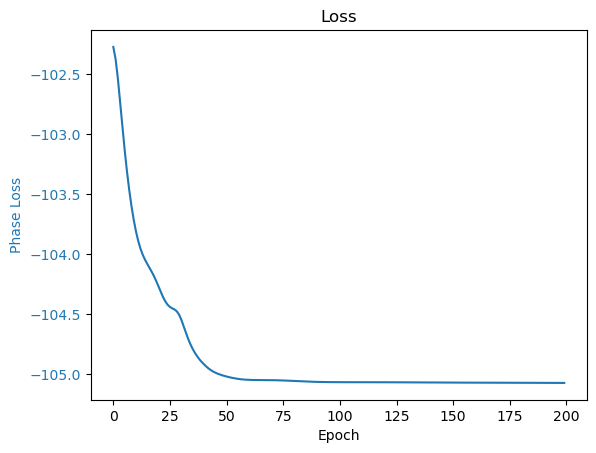

In [12]:
epochs = list(metrics_pha.keys())
loss_vals = [metrics_pha[e]['loss'] for e in epochs]

fig, ax1 = plt.subplots()

ax1.plot(epochs, loss_vals, label="Amplitude CD Loss", color="tab:blue")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Phase Loss", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

plt.title("Loss")
plt.show()

In [13]:
one_hot_states = jnp.eye(visible_units, dtype=jnp.float32)
one_hot_bitstrings = [''.join('1' if s > 0 else '0' for s in state) for state in one_hot_states]

model_phases_raw = model_pha.apply({"params": state_pha.params, "amp": amp_vars}, one_hot_states, method=model_pha.compute_phase)
model_phases_norm = model_phases_raw - model_phases_raw[-1]
model_phases_wrapped = model_phases_norm % (2 * jnp.pi)

model_phase_tuples = sorted(zip(one_hot_bitstrings, model_phases_raw, model_phases_wrapped), key=lambda x: int(x[0], 2))

for bitstring, phase_raw, phase_wrapped in model_phase_tuples:
    print(f"{bitstring}: {phase_raw:.4f} (raw), {phase_wrapped:.4f} (wrapped)")

00000001: 16.1009 (raw), 0.0000 (wrapped)
00000010: 15.7121 (raw), 5.8944 (wrapped)
00000100: 12.6238 (raw), 2.8061 (wrapped)
00001000: 12.5553 (raw), 2.7376 (wrapped)
00010000: 18.6866 (raw), 2.5857 (wrapped)
00100000: 18.2435 (raw), 2.1426 (wrapped)
01000000: 14.0478 (raw), 4.2301 (wrapped)
10000000: 13.5823 (raw), 3.7646 (wrapped)


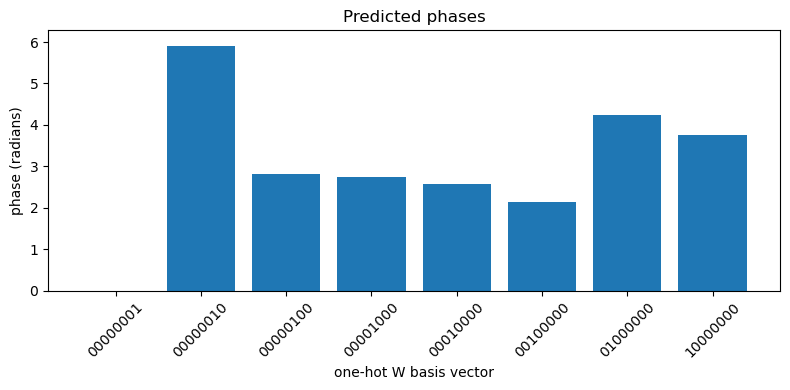

In [14]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar([t[0] for t in model_phase_tuples], [t[2] for t in model_phase_tuples])
ax.set_xlabel("one-hot W basis vector")
ax.set_ylabel("phase (radians)")
ax.set_title("Predicted phases")
ax.set_ylim(0, 2 * jnp.pi)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
w_aug_file_path = Path(data_dir) / f"w_aug_{visible_units}.txt"
w_aug_state_dict = load_state_vector(w_aug_file_path)

phase_offset = np.angle(w_aug_state_dict[one_hot_bitstrings[-1]])

original_phase_tuples = []
for bs in sorted(one_hot_bitstrings, key=lambda x: int(x, 2)):

    amplitude = w_aug_state_dict[bs]
    phase_raw = np.angle(amplitude)  # get raw phase in radians
    phase_norm = phase_raw - phase_offset  # normalize by the last one-hot state
    phase_wrapped = phase_norm % (2 * jnp.pi)

    original_phase_tuples.append((bs, amplitude, phase_raw, phase_wrapped))

for bitstring, amp, phase_raw, phase_wrapped in original_phase_tuples:
    print(f"{bitstring}: {amp:.8f} (ampl), {phase_raw:.4f} (raw), {phase_wrapped:.4f} (wrapped)")

00000001: 0.35348165+0.00712282j (ampl), 0.0201 (raw), 0.0000 (wrapped)
00000010: 0.34222963+0.08876304j (ampl), 0.2538 (raw), 0.2336 (wrapped)
00000100: -0.07679566+0.34511220j (ampl), 1.7898 (raw), 1.7696 (wrapped)
00001000: 0.02867402-0.35238871j (ampl), -1.4896 (raw), 4.7734 (wrapped)
00010000: 0.01964585+0.35300714j (ampl), 1.5152 (raw), 1.4951 (wrapped)
00100000: -0.03371835+0.35194188j (ampl), 1.6663 (raw), 1.6462 (wrapped)
01000000: -0.28657940-0.20705615j (ampl), -2.5159 (raw), 3.7471 (wrapped)
10000000: -0.13468251-0.32689542j (ampl), -1.9616 (raw), 4.3014 (wrapped)


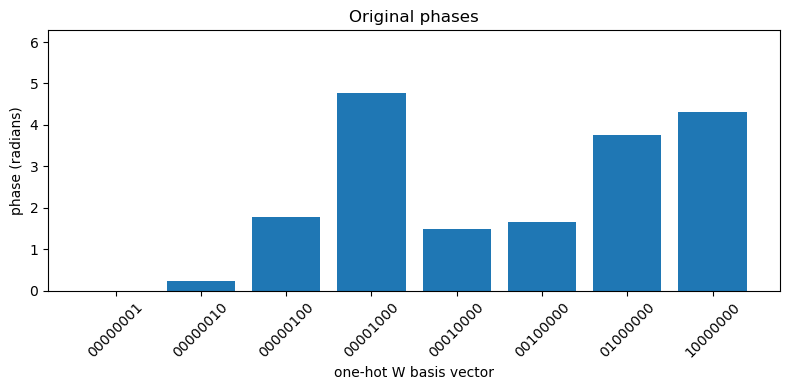

In [16]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar([t[0] for t in original_phase_tuples], [t[3] for t in original_phase_tuples])
ax.set_xlabel("one-hot W basis vector")
ax.set_ylabel("phase (radians)")
ax.set_title("Original phases")
ax.set_ylim(0, 2 * jnp.pi)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()